In [78]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import urllib.request
import urllib.parse
import re
import requests
import numpy as np
from konlpy.tag import Okt
from konlpy.tag import Kkma
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from gensim.models import word2vec
from sklearn.decomposition import PCA




base_url = 'https://www.teamblind.com'
os.chdir('C:/Users/Duri') #chromedriver.exe 의 위치를 저장
okt=Okt()
kkma=Kkma()

In [2]:
topic = {'Military_story' : '/kr/topics/%EA%B5%B0%EB%8C%80%EC%9D%B4%EC%95%BC%EA%B8%B0',
'Recommended_code_and_sequence' :'/kr/topics/%EC%B6%94%EC%B2%9C%EC%BD%94%EB%93%9C%C2%B7%ED%94%84%EB%A6%AC%ED%80%80%EC%8B%9C',
'Blah_Blah' : '/kr/topics/%EB%B8%94%EB%9D%BC%EB%B8%94%EB%9D%BC',
'Stock_and_investment' : '/kr/topics/%EC%A3%BC%EC%8B%9D%C2%B7%ED%88%AC%EC%9E%90',
'love' : '/kr/topics/%EC%8D%B8%C2%B7%EC%97%B0%EC%95%A0',
'Cryptocurrency' : '/kr/topics/%EC%95%94%ED%98%B8%ED%99%94%ED%8F%90',
'Changing_jobs_and_Career' : '/kr/topics/%EC%9D%B4%EC%A7%81%C2%B7%EC%BB%A4%EB%A6%AC%EC%96%B4',
'traveling_and_eating' : '/kr/topics/%EC%97%AC%ED%96%89%C2%B7%EB%A8%B9%EB%B0%A9',
'real_estate' : '/kr/topics/%EB%B6%80%EB%8F%99%EC%82%B0',
'office_life' : '/kr/topics/%ED%9A%8C%EC%82%AC%EC%83%9D%ED%99%9C',
'hobby_life' : '/kr/topics/%EC%A7%81%EC%9E%A5%EC%9D%B8-%EC%B7%A8%EB%AF%B8%EC%83%9D%ED%99%9C',
'Car' : '/kr/topics/%EC%9E%90%EB%8F%99%EC%B0%A8',
'Shopping' : '/kr/topics/%EC%A7%80%EB%A6%84%C2%B7%EC%87%BC%ED%95%91',
'Sports' : '/kr/topics/%EC%8A%A4%ED%8F%AC%EC%B8%A0',
'companion_animals' : '/kr/topics/%EB%B0%98%EB%A0%A4%EB%8F%99%EB%AC%BC',
'Covid_19' : '/kr/topics/%EC%BD%94%EB%A1%9C%EB%82%98-%EB%B0%94%EC%9D%B4%EB%9F%AC%EC%8A%A4',
'Diet' : '/kr/topics/%ED%97%AC%EC%8A%A4%C2%B7%EB%8B%A4%EC%9D%B4%EC%96%B4%ED%8A%B8',
'parenting' : '/kr/topics/%EC%9C%A1%EC%95%84',
'Humor' : '/kr/topics/%EC%9C%A0%EC%9A%B0%EB%A8%B8',
'married_life' : '/kr/topics/%EA%B2%B0%ED%98%BC%EC%83%9D%ED%99%9C',
'Fashion' : '/kr/topics/%ED%8C%A8%EC%85%98%C2%B7%EB%B7%B0%ED%8B%B0',
'TV' : '/kr/topics/TV%C2%B7%EC%97%B0%EC%98%88'}
# Topic별 주소를 딕셔너리 형태로 저장

In [3]:
def drive(url):
    driver = webdriver.Chrome('./chromedriver')
    driver.implicitly_wait(1)
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    return driver, soup
# 크롬을 구동하고 이를soup와 함께 반환하는 함수

In [4]:
def topic_url_crawling(tp):
    contents_url = []
    url=base_url+topic.get(tp)
    driver, temp = drive(url)
    last_height = 0
    n=0
    while n<300: # 페이지다운 횟수 , 300회로 약 2000개 가량의 데이터셋을 확보할 수 있음
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") 
        time.sleep(1) 
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight-50);") 
        time.sleep(1) 
        new_height = driver.execute_script("return document.body.scrollHeight") 
        if new_height == last_height: 
            break
        n+=1
    time.sleep(1.5)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    for div in soup.select('.name'):
        contents_url.append(div.findAll('a',href=True)[0]['href'])
    driver.close()
    return contents_url
# 스크롤링을 진행하고, 페이지의 URL을 받아오는 함수

In [18]:
def page_crawling(url_set):
    title=[]
    contents = []
    company=[]
    company_url=[]
    headers = {'User-Agent': "input your User-Agent"}
    n=0 # headers를 변경해줘야 코드가 원활하게 돌아감
    save=0
    for url in url_set:
        new_url=base_url+url
        req = requests.get(new_url, headers = headers)
        data=req.text
        soup = BeautifulSoup(data, 'html.parser')
        n+=1
        if n>1000: # 중도 차단시 데이터를 보존하고자 중간지점에서 체크포인트 생성
            n=0
            save+=1
            save_data = pd.DataFrame({'title' : title, 'contents':contents,'company':company,'company_url':company_url})
            save_data.to_excel('save'+str(save)+'.xlsx')
        if not soup.select('.not-found') and not url=="#":
            for div in soup.select('.article-view-head'):
                title.append(div.findAll('h2')[0].text)
            contents.append(soup.select('.contents-txt')[0].text)
            div1=soup.select('.name')[0]
            if div1.findAll('a',href=True):
                company.append(div1.text)
                company_url.append(div1.findAll('a',href=True)[0]['href'])
            else:
                company.append(div1.text)
                company_url.append('non')
    return title, contents, company, company_url
# 페이지를 크롤링해 데이터를 가져오는 함수

In [ ]:
def page_crawling_company(url_set):
    company_name=[]
    rate=[]
    headers = {'User-Agent': "input your User-Agent"}
    n=0 # headers를 변경해줘야 코드가 원활하게 돌아감
    for url in url_set:
        new_url=base_url+url
        req = requests.get(new_url, headers = headers)
        data=req.text
        soup = BeautifulSoup(data, 'html.parser')
        n+=1
        if n>100:
            n=0
            print('100개 완료')
        if not soup.select('.not-found') and not url=="#":
            for div in soup.select('.rate'):
                rate.append(re.findall('\d.\d',div.text)[0])
            for div in soup.select('.name'):
                company_name.append(div.text.strip())
    return company_name, rate
# 회사관련 주소를 크롤링해서 회사 정보를 저장하는 함수

In [ ]:
office_life_url = topic_url_crawling('office_life')
office_life_url_data = pd.DataFrame({'office_life_url' : office_life_url})
office_life_url_data.to_excel('office_life_url.xlsx')
# URL 데이터를 가져오고 저장하는 코드

In [ ]:
title_office, contents_office, company_office, company_url_office =page_crawling(office_life_url)
office_life_data = pd.DataFrame({'title_office' : title_office, 'contents_office':contents_office,'company_office':company_office,'company_url_office':company_url_office})
office_life_data.to_excel('blind_data_office.xlsx')
# URL 데이터를 통해 가져온 텍스트 데이터를 중간저장하는 코드

In [ ]:
Changing_jobs_url = topic_url_crawling('Changing_jobs_and_Career')
Changing_jobs_url_data = pd.DataFrame({'Changing_jobs_url' : Changing_jobs_url})
Changing_jobs_url_data.to_excel('urldata.xlsx')
# URL 데이터를 가져오고 저장하는 코드

In [ ]:
title_job, contents_job, company_job, company_url_job =page_crawling(Changing_jobs_url)
Changing_jobs_data = pd.DataFrame({'title_job' : title_job, 'contents_job':contents_job,'company_job':company_job,'company_url_job':company_url_job})
Changing_jobs_data.to_excel('blind_data2.xlsx')
# URL 데이터를 통해 가져온 텍스트 데이터를 중간저장하는 코드

In [36]:
blind_data_job=pd.read_excel('blind_data_job.xlsx',sheet_name='Sheet1')
blind_data_office=pd.read_excel('blind_data_office.xlsx',sheet_name='Sheet1')

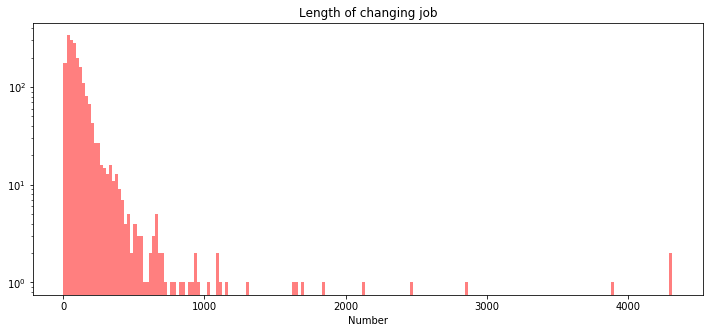

In [7]:
train_job_content=blind_data_job['contents_job'].apply(len)
train_job_title=blind_data_job['title_job'].apply(len)
train_office_content=blind_data_office['contents'].apply(len)
train_office_title=blind_data_office['title'].apply(len)

plt.figure(figsize=(12,5))
plt.hist(train_job_content, bins=200, alpha = 0.5, color='r', label='word')
plt.yscale('log', nonposy = 'clip')
plt.title('Length of changing job')
plt.xlabel('Length')
plt.xlabel('Number')
plt.show()
# 전처리전 확인을 위해 본문의 길이와 단어수를 히스토그램으로 작성

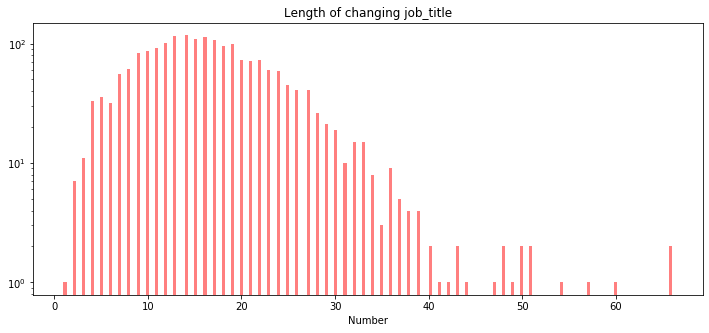

In [8]:
plt.figure(figsize=(12,5))
plt.hist(train_job_title, bins=200, alpha = 0.5, color='r', label='word')
plt.yscale('log', nonposy = 'clip')
plt.title('Length of changing job_title')
plt.xlabel('Length')
plt.xlabel('Number')
plt.show()
# 전처리전 확인을 위해 제목의 길이와 단어수를 히스토그램으로 작성

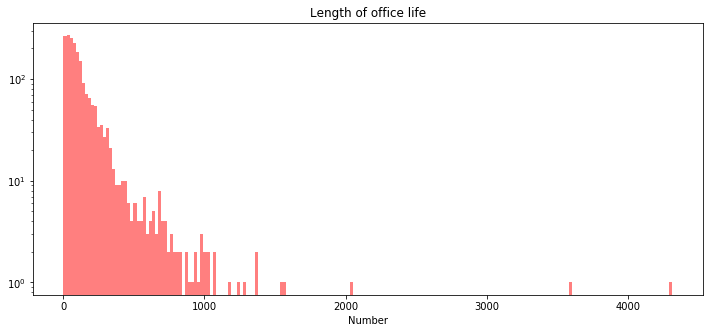

In [9]:
plt.figure(figsize=(12,5))
plt.hist(train_office_content, bins=200, alpha = 0.5, color='r', label='word')
plt.yscale('log', nonposy = 'clip')
plt.title('Length of office life')
plt.xlabel('Length')
plt.xlabel('Number')
plt.show()
# 전처리전 확인을 위해 본문의 길이와 단어수를 히스토그램으로 작성

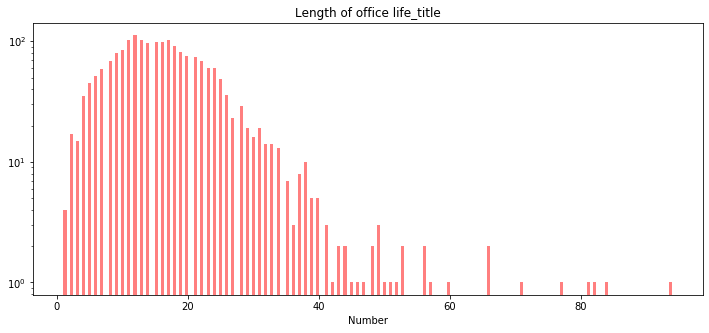

In [10]:
plt.figure(figsize=(12,5))
plt.hist(train_office_title, bins=200, alpha = 0.5, color='r', label='word')
plt.yscale('log', nonposy = 'clip')
plt.title('Length of office life_title')
plt.xlabel('Length')
plt.xlabel('Number')
plt.show()
# 전처리전 확인을 위해 제목의 길이와 단어수를 히스토그램으로 작성

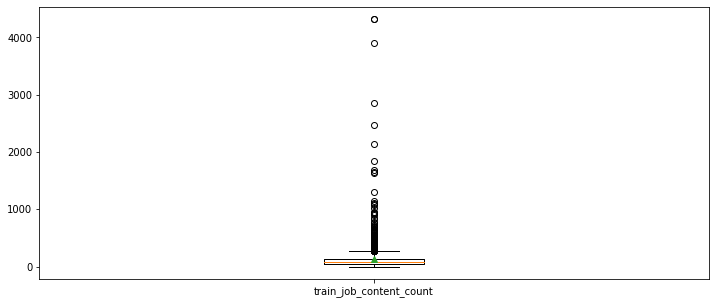

In [15]:
plt.figure(figsize=(12,5))
plt.boxplot(train_job_content, labels=['train_job_content_count'], showmeans=True)
plt.show()
# 전처리전 확인을 위해 제목의 길이와 단어수를 박스플랏으로 작성

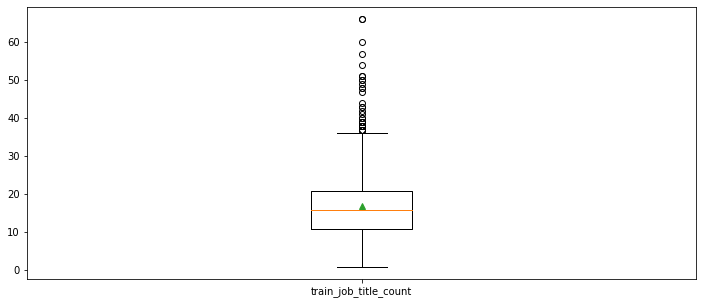

In [13]:
plt.figure(figsize=(12,5))
plt.boxplot(train_job_title, labels=['train_job_title_count'], showmeans=True)
plt.show()
# 전처리전 확인을 위해 본문의 길이와 단어수를 박스플랏으로 작성

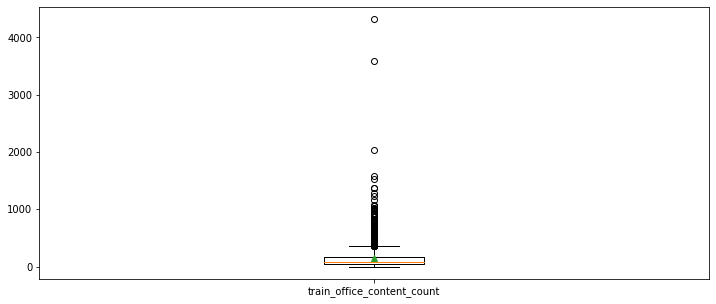

In [16]:
plt.figure(figsize=(12,5))
plt.boxplot(train_office_content, labels=['train_office_content_count'], showmeans=True)
plt.show()
# 전처리전 확인을 위해 제목의 길이와 단어수를 박스플랏으로 작성

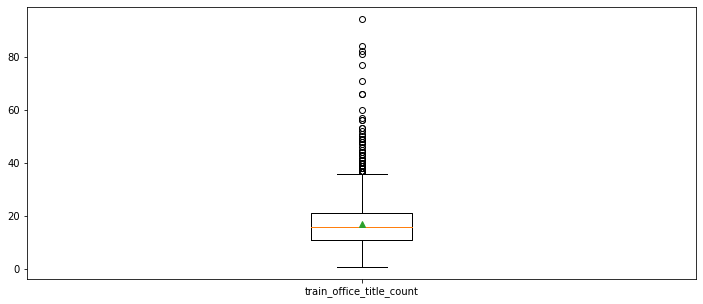

In [17]:
plt.figure(figsize=(12,5))
plt.boxplot(train_office_title, labels=['train_office_title_count'], showmeans=True)
plt.show()
# 전처리전 확인을 위해 본문의 길이와 단어수를 박스플랏으로 작성

In [19]:
def noun_adj_list(list):
    sentences_tag = []
    for sentence in list:
        sentences_tag.append(okt.pos(sentence))
    noun_adj_list=[]
    for sentence in sentences_tag :
        for word, tag in sentence :
#            if tag in ['Noun', 'Adjective'] :    명사 + 형용사 사용시
            if tag in ['Noun'] : # 명사만 사용시
                noun_adj_list.append(word)
    return noun_adj_list
# 워드 클라우드 작성을 위한 처리
# 참고 / https://cossmos.tistory.com/39

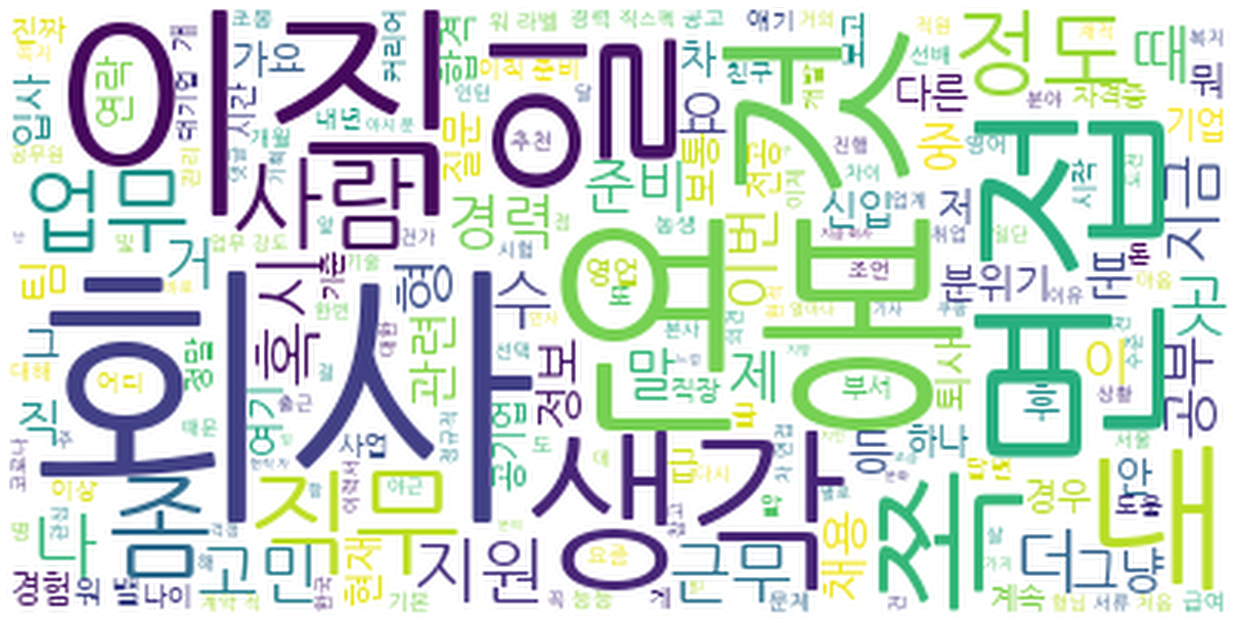

In [20]:
job_data = blind_data_job['contents_job'].tolist()
job_text_set = noun_adj_list(job_data)
job_text_WordCloud=' '.join(job_text_set)
wordcloud_job = WordCloud(font_path='font/NanumGothic.ttf', background_color='white').generate(job_text_WordCloud)
plt.figure(figsize=(22,22)) #이미지 사이즈 지정
plt.imshow(wordcloud_job, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off')
plt.savefig('job_plt.png')
plt.show()
# 이직 토픽 코퍼스를 통한 워드 클라우드

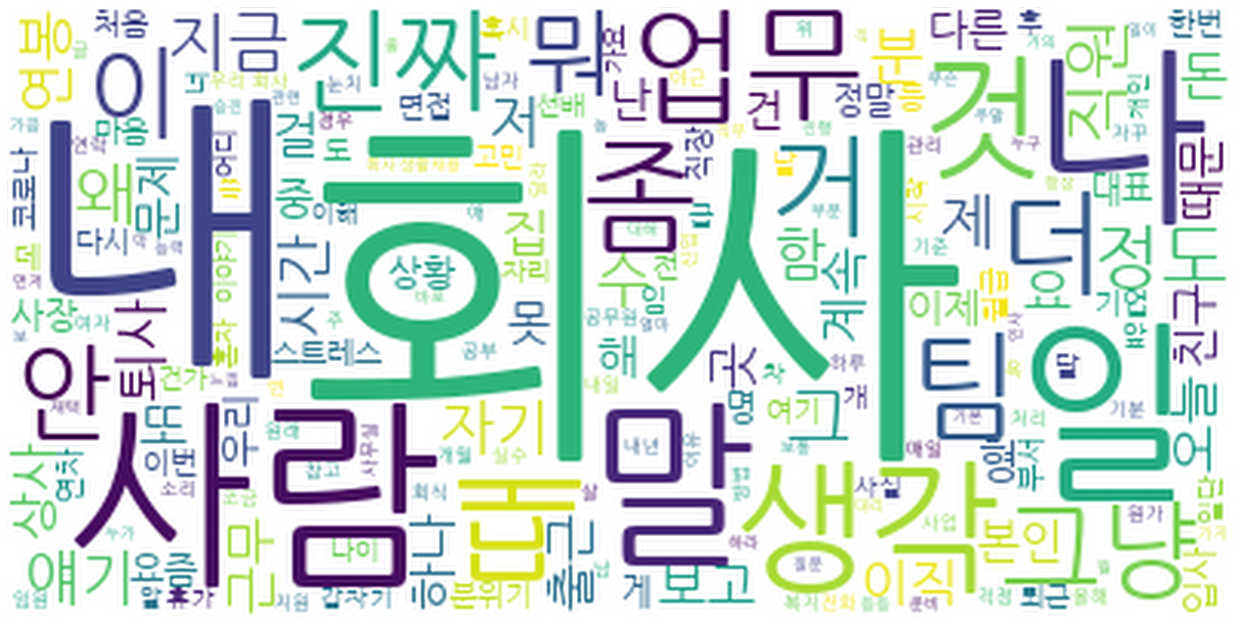

In [21]:
office_data = blind_data_office['contents'].tolist()
office_text_set =  noun_adj_list(office_data)
office_text_WordCloud=' '.join(office_text_set)
wordcloud_office = WordCloud(font_path='font/NanumGothic.ttf', background_color='white').generate(office_text_WordCloud)
plt.figure(figsize=(22,22)) #이미지 사이즈 지정
plt.imshow(wordcloud_office, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off')
plt.savefig('office_plt.png')
plt.show()
# 회사생활 토픽 코퍼스를 통한 워드 클라우드

In [37]:
blind_data_job['company_job'] = blind_data_job['company_job'].apply(lambda x: x.split('\n')[0][1:])
blind_data_office['company'] = blind_data_office['company'].apply(lambda x: x.split('\n')[0][1:])
#회사명만 남기고 불필요한 부분 제거(ex / 태영건설\n · l********\n > 태영건설)

In [38]:
blind_data_job['full_contents']=blind_data_job[['title_job','contents_job']].apply(' '.join, axis=1)
blind_data_office['full_contents']=blind_data_office[['title','contents']].apply(' '.join, axis=1)
# 제목과 본문간의 구문이 불명확한 경우가 많아 2가지를 합쳐서 1개의 콘텐츠로 보기위해서 합침

In [39]:
blind_data_job.drop(['Unnamed: 0','title_job','contents_job','company_url_job'], axis='columns', inplace=True)
blind_data_office.drop(['Unnamed: 0','title','contents','company_url'], axis='columns', inplace=True)
# 불필요해진 열 삭제

In [40]:
blind_data_job['full_contents']=blind_data_job['full_contents'].apply(lambda x: x.strip())
blind_data_office['full_contents']=blind_data_office['full_contents'].apply(lambda x: x.strip())
# 텍스트 앞, 뒤에 공백이 있는 경우가 있어 이를 제거함

In [41]:
blind_data_job['company_job']=blind_data_job['company_job'].apply(lambda x: '스타트업' if x=='새회사' else x)
blind_data_office['company']=blind_data_office['company'].apply(lambda x: '스타트업' if x=='새회사' else x)
# 새 회사를 스타트업으로 변경

In [42]:
blind_data_job['full_contents']=blind_data_job['full_contents'].apply(lambda x: re.sub('http*\S+','',x))
blind_data_office['full_contents']=blind_data_office['full_contents'].apply(lambda x: re.sub('http*\S+','',x))
# 본문에 링크를 올리는 경우가 많아 제거

In [43]:
blind_data_job.columns = ['company','full_contents']
# 이름이 다른 열 이름 수정

In [44]:
blind_data_job['full_contents']=blind_data_job['full_contents'].apply(lambda x: re.sub('\W+',' ',x))
blind_data_office['full_contents']=blind_data_office['full_contents'].apply(lambda x: re.sub('\W+',' ',x))
# 특수문자 제거

In [45]:
blind_data_job['full_contents']=blind_data_job['full_contents'].apply(lambda x: re.sub('\d+',' ',x))
blind_data_office['full_contents']=blind_data_office['full_contents'].apply(lambda x: re.sub('\d+',' ',x))
# 숫자 제거

In [46]:
blind_data_job.dropna(axis=0)
blind_data_office.dropna(axis=0)
#null값 제거

,company,full_contents
0,태영건설,남녀 진급차이 있는 회사 있어 남자는 군대 다녀오고여자는 군대를 안가잔아 호봉으로 ...
1,현대건설,왜 경상도 사람들은 메신저에 사투리로 적나요 ㅋㅋㅋㅋㅋ
2,스타트업,고객사가 외국이면 어느정도 언어는 저는 일본에 있는 기업에서 근무하고있습니다 최근 ...
3,스타트업,한전 인턴 복장 한전 인턴 기간동안 어떻게 입고 다녀야 할까요 채용형이라 평가 받고...
4,삼성SDI,후배 선배 사이 넋두리 좀 들어줘 조언도 부탁해난 년차 접어들었고 후배는 년일했...
...,...,...
1984,스타트업,직장동료에게 반찬 해주면 이상한거야
1985,롯데정보통신,이게 무슨일 회사인지는 모르겠지만 전직으로써 마음이 편치 않다 그대는 비행이 아니더...
1986,국민건강보험공단,평생 수원 고정 근무 가능한 회사 있어 공공기관 사무직 중에
1987,유라코퍼레이션,넥슨 직급체계가 어떻게 되나요 넥슨 및 nxc 네오플 등 직급체계 어떻게 이루어져 있나요


In [47]:
blind_data_job.to_excel('blind_data_job_result.xlsx')
blind_data_office.to_excel('blind_data_office_result.xlsx')
# 전처리 완료데이터 1차 저장

In [ ]:
blind_data_job['changing_job'] = 1
blind_data_office['changing_job'] = 0
contents=blind_data_job['full_contents'].tolist()
contents_temp=blind_data_office['full_contents'].tolist()
changing_job=blind_data_job['changing_job'].tolist()
changing_job_temp=blind_data_office['changing_job'].tolist()
contents.extend(contents_temp)
changing_job.extend(changing_job_temp)
#토큰화를 위해 두개의 데이터를 합침

In [49]:
def tokenizer_okt(sent):
    temp = okt.pos(sent)
    result = []
    for tokens in temp:
        if not tokens[1] == 'Josa' and  not tokens[1] == 'KoreanParticle':
            result.append(tokens[0])
    return result
#전처리와 토크나이저를 수행할 함수를 정의

In [56]:
def tokenizer_okt_tfidf(list):
    return okt.morphs(list)

In [55]:
X = [ tokenizer_okt(x) for x in contents ]

In [61]:
y = np.array(changing_job)

In [59]:
X_ifidf = [ ' '.join(x) for x in X]

In [60]:
vectorizer = TfidfVectorizer(min_df=0.0, analyzer = 'word', ngram_range=(1,3))
X_ifidf_vec = vectorizer.fit_transform(X_ifidf)
# TF-IDF를 활용해 문장의 Vector화

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_ifidf_vec, y, test_size = 0.3)
lm_tfidf = LogisticRegression(class_weight = 'balanced')
lm_tfidf.fit(X_train, y_train)

print("accuracy = ",lm_tfidf.score(X_test, y_test))
print('\n')
preds = lm_tfidf.predict(X_test)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# LogisticRegression을 통한 분류 시행(향휴 다른 모델과 비교할 척도로 활용)

accuracy =  0.8228379513014273


[[518  87]
 [124 462]]


              precision    recall  f1-score   support

           0       0.81      0.86      0.83       605
           1       0.84      0.79      0.81       586

    accuracy                           0.82      1191
   macro avg       0.82      0.82      0.82      1191
weighted avg       0.82      0.82      0.82      1191



In [71]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print("accuracy = ",nb.score(X_test, y_test))
print('\n')
preds = nb.predict(X_test)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# MultinomialNB를 통한 학습(IF-IDF vec)

accuracy =  0.8035264483627204


[[434 171]
 [ 63 523]]


              precision    recall  f1-score   support

           0       0.87      0.72      0.79       605
           1       0.75      0.89      0.82       586

    accuracy                           0.80      1191
   macro avg       0.81      0.80      0.80      1191
weighted avg       0.81      0.80      0.80      1191



In [72]:
SGD = SGDClassifier()
SGD.fit(X_train, y_train)
print("accuracy = ",SGD.score(X_test, y_test))
print('\n')
preds = SGD.predict(X_test)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# SGDClassifier를 통한 학습(IF-IDF vec)

accuracy =  0.8261964735516373


[[514  91]
 [116 470]]


              precision    recall  f1-score   support

           0       0.82      0.85      0.83       605
           1       0.84      0.80      0.82       586

    accuracy                           0.83      1191
   macro avg       0.83      0.83      0.83      1191
weighted avg       0.83      0.83      0.83      1191



In [73]:
num_features = 500  # 문자 벡터 차원 수
min_word_count = 3  # 최소 문자 수
num_workers = 5  # 병렬 처리 스레드 수
context = 10  # 문자열 창 크기
downsampling = 1e-3  # 문자 빈도수 Downsample
model = word2vec.Word2Vec(X, workers=num_workers ,size = num_features, min_count = min_word_count, window  = context, sg=0)

In [74]:
model.wv.most_similar('이직') # 주요 키워드와 벡터적으로 유사한 단어를 탐색

[('준비', 0.9998496174812317),
 ('고민', 0.9997833371162415),
 ('하려고', 0.9997332692146301),
 ('내년', 0.9997169971466064),
 ('취업', 0.9997082352638245),
 ('가야', 0.9996945858001709),
 ('다니면서', 0.9996882677078247),
 ('퇴직', 0.9996880292892456),
 ('하려면', 0.9996743202209473),
 ('토익', 0.9996731877326965)]

In [75]:
model.wv.most_similar('공기업') # 주요 키워드와 벡터적으로 유사한 단어를 탐색

[('삼전', 0.9999599456787109),
 ('한전', 0.9999578595161438),
 ('현재', 0.9999535083770752),
 ('연', 0.9999529719352722),
 ('중소기업', 0.9999499320983887),
 ('인턴', 0.9999487400054932),
 ('공', 0.9999457597732544),
 ('졸', 0.9999455213546753),
 ('에너지', 0.9999446272850037),
 ('은행', 0.9999445080757141)]

In [76]:
model.wv.most_similar('연봉') # 주요 키워드와 벡터적으로 유사한 단어를 탐색

[('급', 0.999510645866394),
 ('복지', 0.9995086193084717),
 ('근무', 0.9994677305221558),
 ('워', 0.999422013759613),
 ('라벨', 0.9994213581085205),
 ('분위기', 0.9992044568061829),
 ('계약', 0.9991567134857178),
 ('밸', 0.999138593673706),
 ('떴던데', 0.9991333484649658),
 ('강도', 0.9990792870521545)]

C:\Users\Duri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Duri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Duri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


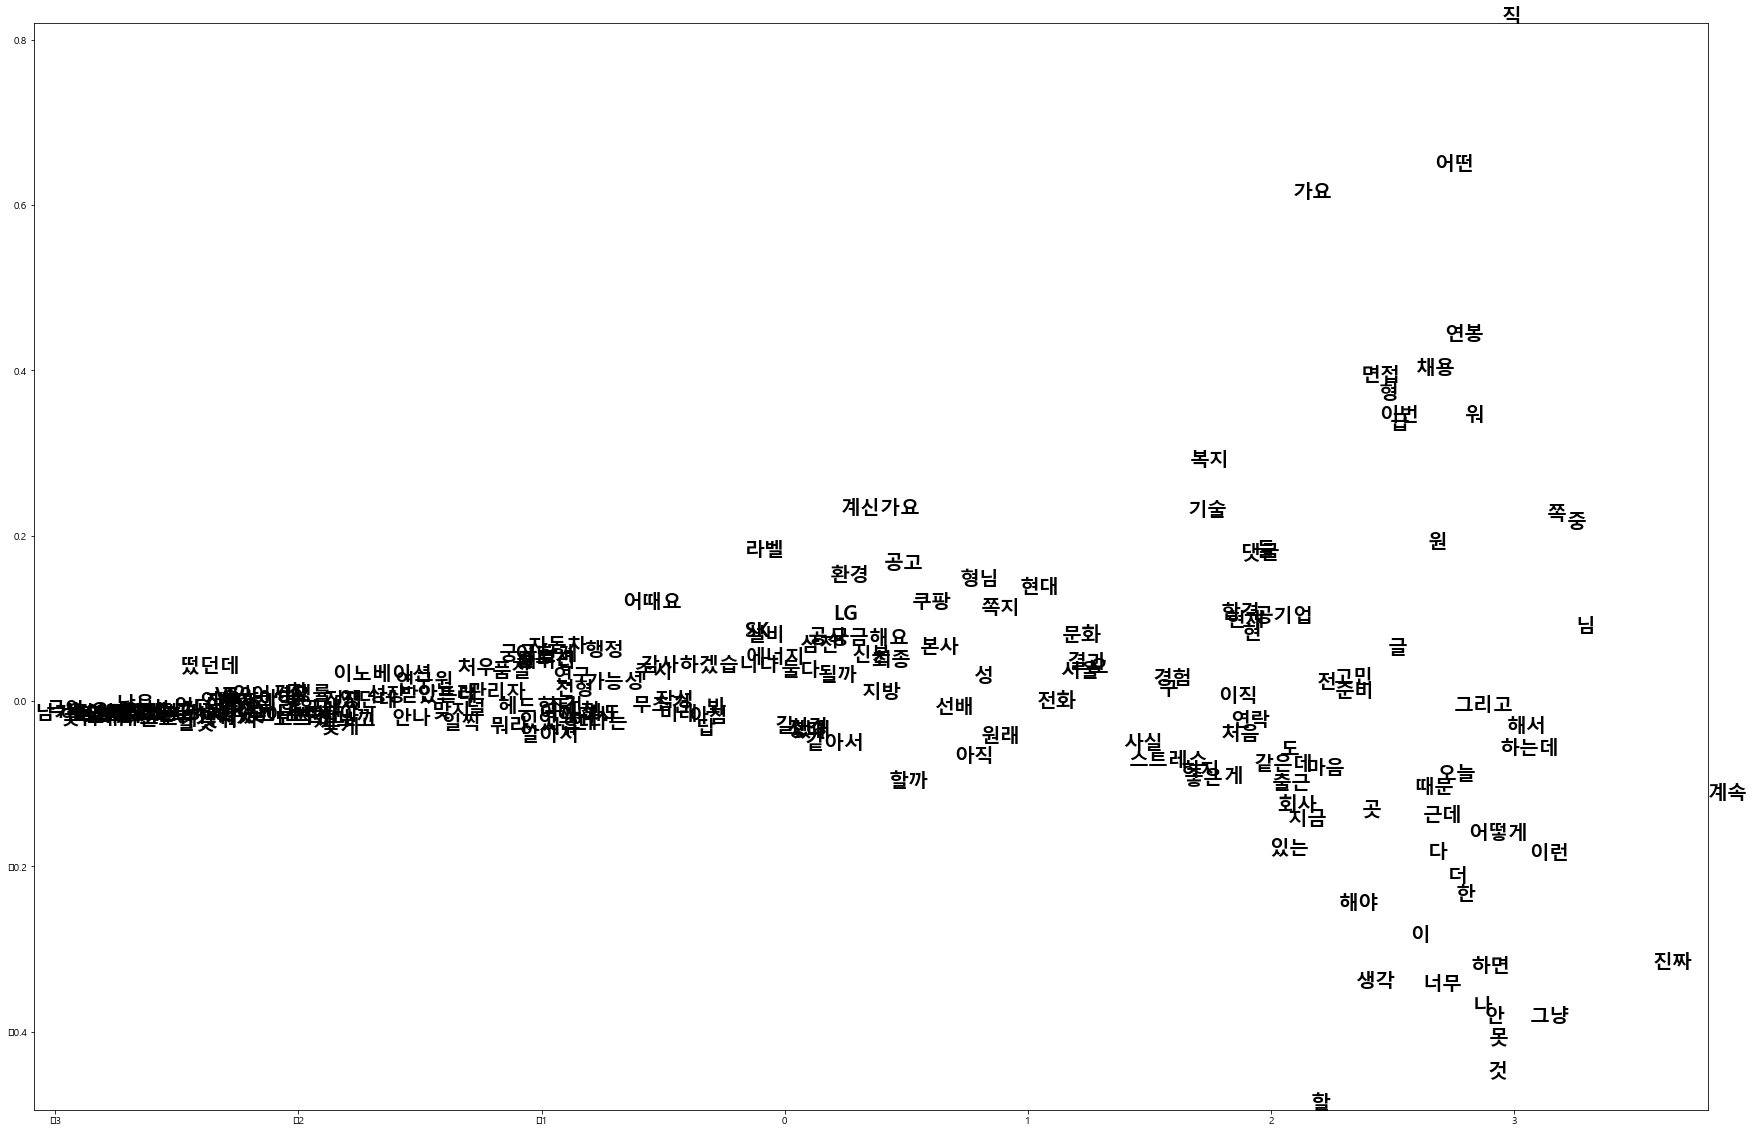

In [90]:
def show_pca():
    pca = PCA(n_components=2)
    pca.fit(X_show)
    x_pca = pca.transform(X_show)
    
    plt.figure(figsize=(30, 20))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max())
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max())
    for i in range(len(X_show)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]), fontdict={'weight': 'bold', 'size': 20})
    plt.show()
plt.rc('font', family='Malgun Gothic')   
vocab = list(model.wv.vocab)
XX = model[vocab]
sz = 50
X_show = XX[:sz,:]
vocab_show = vocab[:sz]
show_pca()
# PCA를 통해 차원을 축소시켜 2차원에 멥핑, 출력은 50단어만 수행

In [81]:
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features), dtype = np.float32)
    num_words = 0
    index2word_set = set(model.wv.index2word)
    for w in words:
        if w in index2word_set:
            num_words = num_words + 1
            feature_vector = np.add(feature_vector, model[w])
#    if not num_words==0:
#        feature_vector = np.divide(feature_vector, num_words)
#    else:
#        feature_vector = np.divide(feature_vector, 1)
    return feature_vector
# 학습한 모델로 코퍼스를 Features로 변환하는 코드

In [82]:
def data_set(contents, model, num_features):
    dataset= list()
    for content in contents:
        dataset.append(get_features(content, model, num_features))
    contentFeatureVecs = np.stack(dataset)
    return contentFeatureVecs
# 전체 코퍼스를 루프를 통해 Numpy Array로 변환

In [85]:
X_vec = data_set(X, model, num_features)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size = 0.3)

C:\Users\Duri\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [86]:
lm_wv = LogisticRegression(class_weight = 'balanced')
lm_wv.fit(X_train, y_train)
print("accuracy = ",lm_wv.score(X_test, y_test))
print('\n')
preds = lm_wv.predict(X_test)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# LogisticRegression를 통한 분석결과(Word2Vec)

accuracy =  0.7573467674223342


[[474 111]
 [178 428]]


              precision    recall  f1-score   support

           0       0.73      0.81      0.77       585
           1       0.79      0.71      0.75       606

    accuracy                           0.76      1191
   macro avg       0.76      0.76      0.76      1191
weighted avg       0.76      0.76      0.76      1191



C:\Users\Duri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [88]:
SGD_wv = SGDClassifier()
SGD_wv.fit(X_train, y_train)
print("accuracy = ",SGD_wv.score(X_test, y_test))
print('\n')
preds = SGD_wv.predict(X_test)
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
# SGDClassifier를 통한 분석결과(Word2Vec)

accuracy =  0.7086481947942905


[[512  73]
 [274 332]]


              precision    recall  f1-score   support

           0       0.65      0.88      0.75       585
           1       0.82      0.55      0.66       606

    accuracy                           0.71      1191
   macro avg       0.74      0.71      0.70      1191
weighted avg       0.74      0.71      0.70      1191

